#### Input

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from helpers import plot_class
from helpers import helpfunction as helper

In [2]:
# Matplotlib help
plt.rcParams.update({"axes.titlesize": "medium"})
plt_h = 4.65

def get_fig(ncols, nleg):
    fig, ax = plt.subplots(
        ncols=ncols,
        nrows=2,
        figsize=(3.5 * ncols + 2 * nleg, plt_h),
        gridspec_kw={"height_ratios": [3, 1]},
        constrained_layout=True,
    )
    return fig, ax

#### Constants

In [3]:
sideband = True
run12 =False
run3 = False
fake = 0

In [4]:
pot_dict = {}
master_query = "(slpdg==12)"
title_str = ''
pi0_scale_bool = True
dirt_bool = True
show_lee_bool = False
maximum_uni_per_type = 5000

if not run12 + run3 + sideband + fake: # Full unblinded data.
    full_sample = True
    print('Unblinded sample')
    beam_on = "on"
    master_query += ("& optical_filter")
    
elif (run12 + run3 + sideband)==1:
    full_sample = False
    title_str = r"Reconstructed $\nu_e$ Energy > 0.9 GeV"
    plt_h = 4.9 # slightly higher plots when title is 2 lines
    beam_on = 'sideband'
    master_query += ("& optical_filter & (reco_e>0.9)")
    if run12:
        # POT needs to be adapted! WIP
        master_query+= ' & (Run<3 | (sample!=2 & sample!=9))'
        
    elif run3:
        # POT needs to be adapted! WIP
        master_query+= ' & (Run==3 | (sample!=2 & sample!=9))'
    else:
        print('Full sideband')
elif fake:
    full_sample = True
    title_str = r"Fake data-set {}".format(fake)
    plt_h = 4.9 # slightly higher plots when title is 2 lines
    beam_on = 'set{}'.format(fake)
    pot_dict = {'EXT': 1, 'E1DCNT_wcut': 0} # set the beam off to 0
    pi0_scale_bool = False
    dirt_bool = False
    show_lee_bool = True
    maximum_uni_per_type = 100
    # No optical filter if fake dataset!
    if fake==5:
        # Manually fix problem with the POT:
        pot_dict['pot'] = 9.00e20
else:
    print('Not possible!')
print(beam_on,pot_dict, master_query)

input_file = "./input/July2020/lite/after_training.pckl"
output_dir = "./output/nue/datamc/{}/".format(beam_on)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

Full sideband
sideband {} (slpdg==12)& optical_filter & (reco_e>0.9)


In [5]:
plotter = plot_class.Plotter(
    input_file,
    signal="nue",
    genie_version="mcc9.1",
    beam_on=beam_on,
    dirt = dirt_bool,
    pot_dict=pot_dict,
    master_query=master_query,
    load_syst= helper.syst_weights,
    show_lee = show_lee_bool,
    pi0_scaling= pi0_scale_bool,
    n_uni_max=maximum_uni_per_type
)

Applying the master query on the systematic universes
weightsFlux
weightsGenie
weightsReint
Using the spline weights as in MCC9.1 Genie V3 tune 1
Empirical scaling of 1-0.4*E applied on events with neutral pions.
data[beam_on]["pot"] {(9, 0): 6.849e+20}
data[beam_on]["triggers"] {(9, 0): 160471177.0}
data[beam_off]["triggers"] {(2, 1): 65353724.0, (2, 0): 151574089.0, (2, 3): 205406582.0}
All plots are scaled to 6.85e+20 POT, Beam_on data corresponds to 6.85e+20 POT
Loaded all daughter dataframes.
Started loading systematic weights.

Loaded all universes for weightsFlux.
Loaded all universes for weightsGenie.
Loaded all universes for weightsReint.
Initialisation completed!


In [8]:
print(plotter.keys)

{'secondshower_Y_nhit', 'shr_tkfit_dedx_nhits_y_v', 'knobThetaDelta2Npiup', 'n_pfp_farvtx', 'reco_e', 'shr_tkfit_4cm_dedx_wm_v', 'reco_nu_vtx_z', 'trk_llr_pid_score_v', 'n_pfps', 'nu_purity_from_pfp', 'true_fid_vol', 'merge_bestdot', 'backtracked_start_z', 'reco_nu_vtx_sce_x', 'pfp_clusters_v', 'weightTune', 'true_vtx_distance', 'reco_nu_vtx_sce_y', 'shr_tkfit_nhits_v', 'merge_bestdist', 'n_showers', 'shr_theta_v', 'backtracked_pdg', 'n_showers_contained', 'trk_score_v', 'shr_moliere_avg_v', 'topological_score', 'score_other_min', 'backtracked_pz', 'trk_sce_start_y_v', 'CosmicIPAll3D', 'shr_tkfit_2cm_dedx_Y', 'knobVecFFCCQEup', 'knobAxFFCCQEdn', 'weightSplineTimesTune', 'reco_nu_vtx_x', 'backtracked_py', 'run', 'score_other_mean', 'interaction', 'CosmicDirAll3D', 'trk_sce_start_x_v', 'trk_at_vtx', 'shr_tkfit_gap10_dedx_y_v', 'trk_sce_start_z_v', 'shr_energy_y_v', 'contained_fraction', 'knobVecFFCCQEdn', 'knobCCMECdn', 'knobCCMECup', 'trk_phi_v', 'trk_theta_v', 'trk_sce_end_y_v', 'score

In [9]:
print(plotter.title_str)

MicroBooNE 6.8e20$\,$POT, Preliminary


### Plots

#### Additions to signal sample plots

In [9]:
# purity for every step per  / can take quite some time
if True:
    cats = {2: 11, 1: 10, 3: 1}
    selectors = ["daughter==0", "e_candidate & preselect", "e_candidate & select"]  # q_s
    labs = ["NeutrinoID", "Pre-selection", "Selection"]

    for selector, lab in zip(selectors, labs):
        ratio, purity = plotter.get_ratio_and_purity(selector, return_syst_err=True)
        print("{} \tPurity: {:.2%}+-{:.2%}".format(lab, *purity))
        print("{} \tRatio: {:.2f}+-{:.2f}".format(lab, ratio[0], ratio[2]))

weightsFlux fractional error: 9.03%
weightsGenie fractional error: 15.41%
weightsReint fractional error: 2.06%
knobThetaDelta2Npi fractional error: 1.45%
knobDecayAngMEC fractional error: 0.05%
knobRPA fractional error: 0.26%
knobVecFFCCQE fractional error: 0.03%
knobAxFFCCQE fractional error: 0.01%
MC stat fractional errs: 0.78%
NeutrinoID 	Purity: 8.17%+-0.07%
NeutrinoID 	Ratio: 0.94+-0.17
weightsFlux fractional error: 9.31%
weightsGenie fractional error: 16.65%
weightsReint fractional error: 1.96%
knobThetaDelta2Npi fractional error: 1.55%
knobDecayAngMEC fractional error: 0.01%
knobRPA fractional error: 0.02%
knobVecFFCCQE fractional error: 0.02%
knobAxFFCCQE fractional error: 0.01%
MC stat fractional errs: 0.91%
Pre-selection 	Purity: 15.15%+-0.16%
Pre-selection 	Ratio: 0.99+-0.19
weightsFlux fractional error: 6.52%
weightsGenie fractional error: 14.64%
weightsReint fractional error: 1.14%
knobThetaDelta2Npi fractional error: 1.70%
knobDecayAngMEC fractional error: 0.27%
knobRPA f

#### Data/MC comparison

MC category: $\nu_e$ CC N$\pi$: 31. 	#entries 6080
MC category: $\nu_e$ CC 0$\pi$0p: 12. 	#entries 1939
MC category: $\nu_e$ CC 0$\pi$Np: 72. 	#entries 11807
MC category: $\nu_{\mu}$ CC other: 2.4 	#entries 30
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 6.3 	#entries 102
MC category: $\nu$ NC: 0.54 	#entries 20
MC category: $\nu$ NC $\pi^{0}$: 3.9 	#entries 38
MC category: Cosmic: 3.9 	#entries 112
MC category: Out of FV: 2.6 	#entries 77
Calculating ratio and purity
weightsFlux fractional error: 6.52%
weightsGenie fractional error: 14.64%
weightsReint fractional error: 1.14%
knobThetaDelta2Npi fractional error: 1.70%
knobDecayAngMEC fractional error: 0.27%
knobRPA fractional error: 0.13%
knobVecFFCCQE fractional error: 0.38%
knobAxFFCCQE fractional error: 0.11%
MC stat fractional errs: 1.47%
MC category: $\nu_e$ CC N$\pi$: 31. 	#entries 6080
MC category: $\nu_e$ CC 0$\pi$0p: 12. 	#entries 1939
MC category: $\nu_e$ CC 0$\pi$Np: 72. 	#entries 11807
MC category: $\nu_{\mu}$ CC other: 2.4 	#en

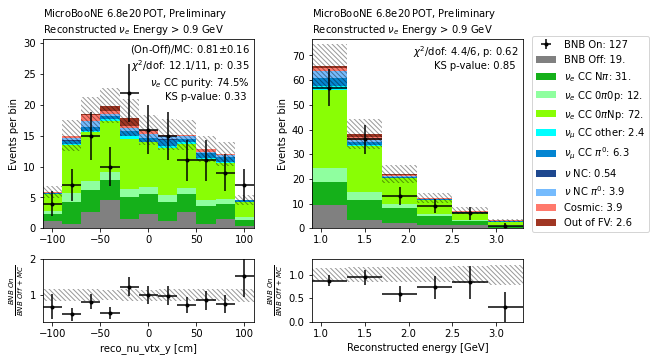

In [10]:
# Janets plot
fig, ax = get_fig(2,1)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[0],
    "reco_nu_vtx_y",
    "reco_nu_vtx_y [cm]",
    N_bins=11,
    x_min=-110,
    x_max=110,
    query="(select & e_candidate)",
    legend=False,
    title_str=title_str,
    kind="cat",
    y_max_scaler= 1.15
)
plot_class.add_text(ax[0][0], [ratio,purity,ks_p,cnp], text_loc)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[1],
    "reco_e",
    "Reconstructed energy [GeV]",
    N_bins=6,
    x_min=0.9,
    x_max=3.3,
    query="(select & e_candidate)",
    legend=True,
    title_str=title_str,
    kind="cat"
)
plot_class.add_text(ax[0][1], [None,None,ks_p,cnp], text_loc)

fig.savefig(output_dir + "event_reco_e.pdf", bbox_inches="tight")

In [11]:
if full_sample:
    query = (
        "(reco_fid_vol & contained_fraction>0.4 & daughter==0)"
    )
    fig, ax = get_fig(3,1)

    ax[0][0].axvspan(0, 0.15, facecolor="red", alpha=0.1)
    ax[1][0].axvspan(0, 0.15, facecolor="red", alpha=0.1)
    ax[0][1].axvspan(0, 30, facecolor="red", alpha=0.1)
    ax[1][1].axvspan(0, 30, facecolor="red", alpha=0.1)
    ax[0][2].axvspan(-1, -.98, facecolor="red", alpha=0.1)
    ax[1][2].axvspan(-1, -.98, facecolor="red", alpha=0.1)
    ax[0][2].axvspan(.98, 1, facecolor="red", alpha=0.1)
    ax[1][2].axvspan(.98, 1, facecolor="red", alpha=0.1)

    ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
        ax.T[0],
        "topological_score",
        r"Event topological score",
        N_bins=20,
        x_min=0,
        x_max=1,
        query=query,
        legend=False,
        title_str=title_str,
        kind="cat",
    )
    plot_class.add_text(ax[0][0], [ratio,purity,ks_p,cnp], text_loc)

    ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
        ax.T[1],
        "CosmicIPAll3D",
        r"Cosmic impact parameter (CosmicIPAll3D) [cm]",
        N_bins=20,
        x_min=0,
        x_max=200,
        query=query,
        title_str=title_str,
        legend=False,
        kind="cat",
    )
    plot_class.add_text(ax[0][1], [ratio,purity,ks_p,cnp], text_loc)

    ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
        ax.T[2],
        "CosmicDirAll3D",
        r"Cosmic impact direction (CosmicDirAll3D) [cm]",
        N_bins=20,
        x_min=-1,
        x_max=1,
        title_str=title_str,
        query=query,
        legend=True,
        kind="cat",
    )
    plot_class.add_text(ax[0][2], [ratio,purity,ks_p,cnp], text_loc)

    fig.savefig(output_dir + "presel_1.pdf", bbox_inches="tight")

In [12]:
# Preselection queries
if full_sample:
    query = "reco_fid_vol & \
             shr_energy_y_v>0 & \
             shr_tkfit_dedx_nhits_y_v>0 & \
             topological_score > 0.15 & \
             pfp_generation_v==2 & \
             trk_llr_pid_score_v>0.4"


    # the cosmic IP variables demand somehow that there is a shower in the event, therefore, they are left out of this cut.
    fig, ax = get_fig(3,1)

    ax[0][0].axvspan(0.3, 1, facecolor="red", alpha=0.1)
    ax[1][0].axvspan(0.3, 1, facecolor="red", alpha=0.1)
    ax[0][1].axvspan(0.5, 2.5, facecolor="red", alpha=0.1)
    ax[1][1].axvspan(0.5, 2.5, facecolor="red", alpha=0.1)
    ax[0][2].axvspan(0, 100, facecolor="red", alpha=0.1)
    ax[1][2].axvspan(0, 100, facecolor="red", alpha=0.1)

    ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
        ax.T[0],
        "trk_score_v",
        r"Track score",
        N_bins=20,
        x_min=0,
        x_max=0.5,
        query=query,
        legend=False,
        show_syst=False,
        title_str=title_str,
        kind="pdg",
        y_label="Showers per bin",
    )
    plot_class.add_text(ax[0][0], [None,purity,ks_p,cnp], text_loc, y=1/3)
    
    ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
        ax.T[1],
        "pfp_clusters_v",
        r"Number of planes",
        N_bins=3,
        x_min=0.5,
        x_max=3.5,
        query=query,
        legend=False,
        show_syst=False,
        title_str=title_str,
        kind="pdg",
        y_label="Showers per bin",
    )
    plot_class.add_text(ax[0][1], [None,purity,ks_p,cnp], text_loc)

    query += " & e_candidate & \
                 contained_fraction>0.4 & \
                 CosmicIPAll3D>30 & \
                 CosmicDirAll3D>-0.98 & \
                 CosmicDirAll3D<0.98"

    ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
        ax.T[2],
        "shr_energy_y_v",
        r"Reconstructed shower energy [GeV]",
        N_bins=20,
        x_min=0,
        x_max=2000,
        query=query,
        legend=True,
        title_str=title_str,
        kind="pdg",
        y_label="Showers per bin",
    )
    plot_class.add_text(ax[0][2], [ratio,purity,ks_p,cnp], text_loc, y=1/3)

    ax[0][0].set_ylim(ax[0][0].get_ylim()[1]/5e1, ax[0][0].get_ylim()[1]*1.25)
    ax[0][0].set_yscale("log")
    ax[0][2].set_ylim(max(ax[0][2].get_ylim()[1]/1e3,1), ax[0][2].get_ylim()[1]*1.25)
    ax[0][2].set_yscale("log")

    fig.savefig(output_dir + "presel_2.pdf", bbox_inches="tight")

MC category: $p$: 3.2 	#entries 53
MC category: $\mu$: 18. 	#entries 225
MC category: $\pi^{\pm}$: 11. 	#entries 223
MC category: $K$: 0.24 	#entries 4
MC category: Cosmic: 194. 	#entries 2790
MC category: $\gamma$: 805. 	#entries 12324
MC category: $e$: 217. 	#entries 37537
Calculating ratio and purity
weightsFlux fractional error: 9.31%
weightsGenie fractional error: 16.65%
weightsReint fractional error: 1.96%
knobThetaDelta2Npi fractional error: 1.55%
knobDecayAngMEC fractional error: 0.01%
knobRPA fractional error: 0.02%
knobVecFFCCQE fractional error: 0.02%
knobAxFFCCQE fractional error: 0.01%
MC stat fractional errs: 0.91%
MC category: $p$: 3.2 	#entries 53
MC category: $\mu$: 18. 	#entries 225
MC category: $\pi^{\pm}$: 11. 	#entries 223
MC category: $K$: 0.24 	#entries 4
MC category: Cosmic: 194. 	#entries 2790
MC category: $\gamma$: 805. 	#entries 12324
MC category: $e$: 217. 	#entries 37537
Obtained ratio and purity from dict


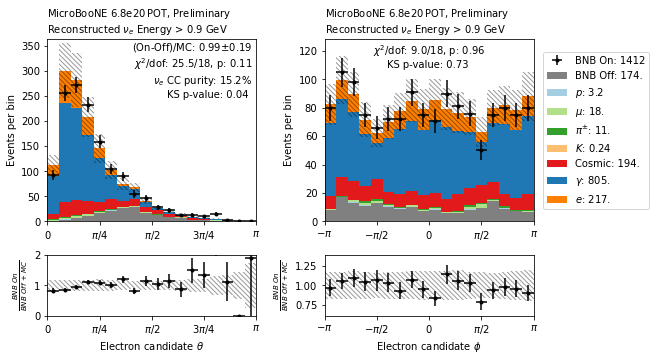

In [13]:
query = "(preselect & e_candidate)"

fig, ax = get_fig(2,1)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[0],
    "shr_theta_v",
    r"Electron candidate $\theta$",
    N_bins=18,
    x_min=0,
    x_max=np.pi,
    query=query,
    legend=False,
    title_str=title_str,
    kind="pdg",
)
plot_class.add_text(ax[0][0], [ratio,purity,ks_p,cnp], text_loc)

ax[1][0].set_xticks(helper.theta_ticks)
ax[1][0].set_xticklabels(helper.theta_labs)
ax[0][0].set_xticks(helper.theta_ticks)
ax[0][0].set_xticklabels(helper.theta_labs)


ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[1],
    "shr_phi_v",
    r"Electron candidate $\phi$",
    N_bins=18,
    x_min=-np.pi,
    x_max=np.pi,
    query=query,
    legend=True,
    title_str=title_str,
    kind="pdg",
    y_max_scaler = 1.1
)
plot_class.add_text(ax[0][1], [None,None,ks_p,cnp], text_loc)

ax[1][1].set_xticks(helper.phi_ticks)
ax[1][1].set_xticklabels(helper.phi_labs)
ax[0][1].set_xticks(helper.phi_ticks)
ax[0][1].set_xticklabels(helper.phi_labs)

fig.savefig(output_dir + "e_cand_theta_phi.pdf", bbox_inches="tight")

## Shower fields
1. feature shr_dist_v (0.406786)
2. feature shr_moliere_avg_v (0.115516)
3. feature shr_tkfit_dedx_y_v (0.103206)
4. feature shr_tkfit_2cm_dedx_Y (0.088309)
5. feature shr_tkfit_4cm_dedx_wm_v (0.080856)
6. feature shr_tkfit_gap10_dedx_y_v (0.078377)
7. feature shr_subclusters_v (0.048331)
8. feature secondshower_Y_nhit (0.046542)
9. feature shr_tkfit_hitratio_v (0.032077)

MC category: $p$: 3.2 	#entries 53
MC category: $\mu$: 18. 	#entries 225
MC category: $\pi^{\pm}$: 11. 	#entries 223
MC category: $K$: 0.24 	#entries 4
MC category: Cosmic: 194. 	#entries 2790
MC category: $\gamma$: 805. 	#entries 12324
MC category: $e$: 217. 	#entries 37537
Calculating ratio and purity
weightsFlux fractional error: 9.31%
weightsGenie fractional error: 16.65%
weightsReint fractional error: 1.96%
knobRPA fractional error: 0.02%
knobVecFFCCQE fractional error: 0.02%
knobThetaDelta2Npi fractional error: 1.55%
knobDecayAngMEC fractional error: 0.01%
knobAxFFCCQE fractional error: 0.01%
MC stat fractional error: 0.91%
MC category: $p$: 3.2 	#entries 53
MC category: $\mu$: 18. 	#entries 225
MC category: $\pi^{\pm}$: 11. 	#entries 223
MC category: $K$: 0.24 	#entries 4
MC category: Cosmic: 194. 	#entries 2790
MC category: $\gamma$: 805. 	#entries 12324
MC category: $e$: 217. 	#entries 37537
Obtained ratio and purity from dict


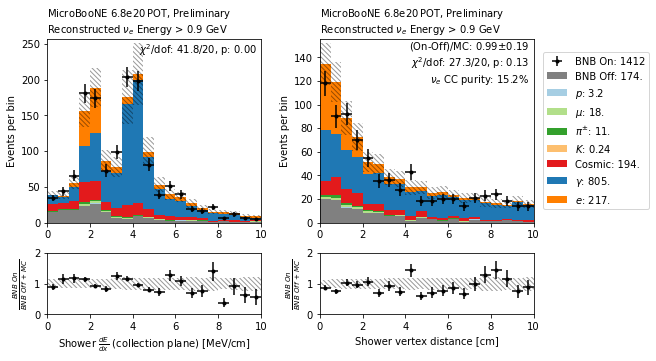

In [10]:
# Neutrino 2020
fig, ax = get_fig(2,1)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[0],
    "shr_tkfit_dedx_y_v",
    r"Shower $\frac{dE}{dx}$ (collection plane) [MeV/cm]",
    N_bins=20,
    x_min=0,
    x_max=10,
    legend=False,
    title_str=title_str,
    query="e_candidate>0 & preselect",
    kind="pdg",
)
plot_class.add_text(ax[0][0], [None,None,None,cnp], text_loc)


ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[1],
    "shr_dist_v",
    "Shower vertex distance [cm]",
    N_bins=20,
    x_min=0,
    x_max=10,
    legend=True,
    title_str=title_str,
    query="e_candidate>0 & preselect",
    
    kind="pdg",
)
plot_class.add_text(ax[0][1], [ratio,purity,None,cnp], text_loc)

[x.set_ylim(0.0, 2) for x in ax[1]]

fig.savefig(output_dir + "e_cand_1.pdf", bbox_inches="tight")

MC category: $p$: 3.2 	#entries 53
MC category: $\mu$: 18. 	#entries 225
MC category: $\pi^{\pm}$: 11. 	#entries 223
MC category: $K$: 0.24 	#entries 4
MC category: Cosmic: 194. 	#entries 2790
MC category: $\gamma$: 805. 	#entries 12324
MC category: $e$: 217. 	#entries 37537
Obtained ratio and purity from dict
MC category: $p$: 3.2 	#entries 53
MC category: $\mu$: 18. 	#entries 225
MC category: $\pi^{\pm}$: 11. 	#entries 223
MC category: $K$: 0.24 	#entries 4
MC category: Cosmic: 194. 	#entries 2790
MC category: $\gamma$: 805. 	#entries 12324
MC category: $e$: 217. 	#entries 37537
Obtained ratio and purity from dict
MC category: $p$: 3.2 	#entries 53
MC category: $\mu$: 18. 	#entries 225
MC category: $\pi^{\pm}$: 11. 	#entries 223
MC category: $K$: 0.24 	#entries 4
MC category: Cosmic: 194. 	#entries 2790
MC category: $\gamma$: 805. 	#entries 12324
MC category: $e$: 217. 	#entries 37537
Obtained ratio and purity from dict


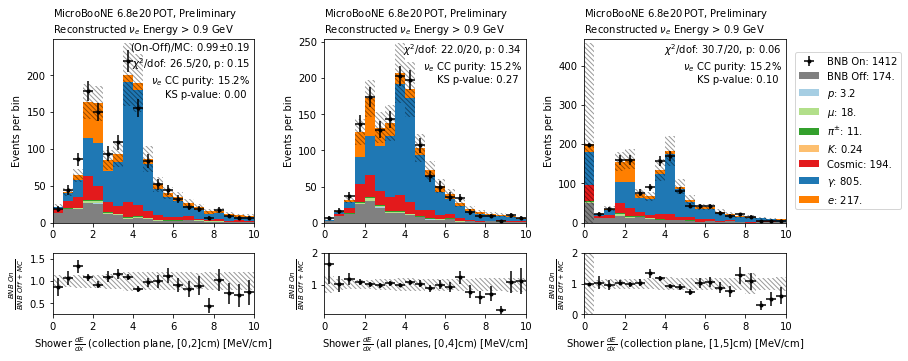

In [15]:
fig, ax = get_fig(3,1)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[0],
    "shr_tkfit_2cm_dedx_Y",
    r"Shower $\frac{dE}{dx}$ (collection plane, [0,2]cm) [MeV/cm]",
    N_bins=20,
    x_min=0,
    x_max=10,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str=title_str,
    kind="pdg",
)
plot_class.add_text(ax[0][0], [ratio,purity,ks_p,cnp], text_loc)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[1],
    "shr_tkfit_4cm_dedx_wm_v",
    r"Shower $\frac{dE}{dx}$ (all planes, [0,4]cm) [MeV/cm]",
    N_bins=20,
    x_min=0,
    x_max=10,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str=title_str,
    kind="pdg",
)
plot_class.add_text(ax[0][1], [None,purity,ks_p,cnp], text_loc)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[2],
    "shr_tkfit_gap10_dedx_y_v",
    r"Shower $\frac{dE}{dx}$ (collection plane, [1,5]cm) [MeV/cm]",
    N_bins=20,
    x_min=0,
    x_max=10,
    legend=True,
    title_str=title_str,
    query="e_candidate>0 & preselect",  
    kind="pdg",
)
plot_class.add_text(ax[0][2], [None,purity,ks_p,cnp], text_loc)

fig.savefig(output_dir + "e_cand_dedx.pdf", bbox_inches="tight")

MC category: $p$: 3.2 	#entries 53
MC category: $\mu$: 18. 	#entries 225
MC category: $\pi^{\pm}$: 11. 	#entries 223
MC category: $K$: 0.24 	#entries 4
MC category: Cosmic: 194. 	#entries 2790
MC category: $\gamma$: 805. 	#entries 12324
MC category: $e$: 217. 	#entries 37537
Obtained ratio and purity from dict
MC category: $p$: 3.2 	#entries 53
MC category: $\mu$: 18. 	#entries 225
MC category: $\pi^{\pm}$: 11. 	#entries 223
MC category: $K$: 0.24 	#entries 4
MC category: Cosmic: 194. 	#entries 2790
MC category: $\gamma$: 805. 	#entries 12324
MC category: $e$: 217. 	#entries 37537
Obtained ratio and purity from dict
MC category: $p$: 3.2 	#entries 53
MC category: $\mu$: 18. 	#entries 225
MC category: $\pi^{\pm}$: 11. 	#entries 223
MC category: $K$: 0.24 	#entries 4
MC category: Cosmic: 194. 	#entries 2790
MC category: $\gamma$: 805. 	#entries 12324
MC category: $e$: 217. 	#entries 37537
Obtained ratio and purity from dict


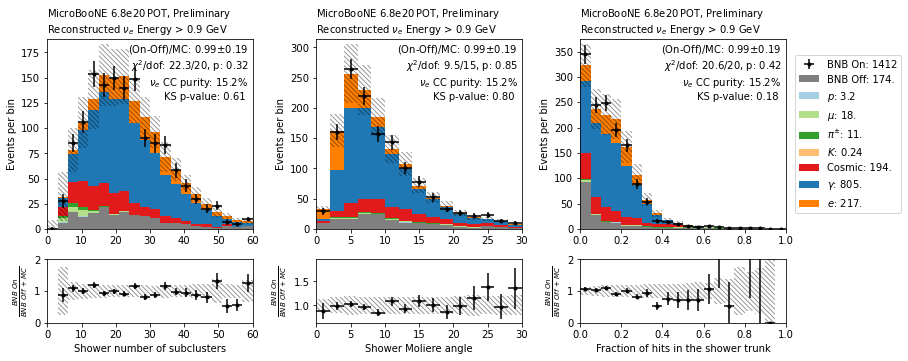

In [16]:
fig, ax = get_fig(3,1)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[0],
    "shr_subclusters_v",
    r"Shower number of subclusters",
    N_bins=20,
    x_min=0,
    x_max=60,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str=title_str,
    kind="pdg",
)
plot_class.add_text(ax[0][0], [ratio,purity,ks_p,cnp], text_loc)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[1],
    "shr_moliere_avg_v",
    r"Shower Moliere angle",
    N_bins=15,
    x_min=0,
    x_max=30,
    legend=False,
    title_str=title_str,
    query="e_candidate>0 & preselect",
    kind="pdg",
)
plot_class.add_text(ax[0][1], [ratio,purity,ks_p,cnp], text_loc)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[2],
    "shr_tkfit_hitratio_v",
    r"Fraction of hits in the shower trunk",
    N_bins=20,
    x_min=0,
    x_max=1,
    title_str=title_str,
    legend=True,
    query="e_candidate>0 & preselect",
    kind="pdg",
)
plot_class.add_text(ax[0][2], [ratio,purity,ks_p,cnp], text_loc)

fig.savefig(output_dir + "e_cand_2.pdf", bbox_inches="tight")

MC category: $p$: 3.2 	#entries 53
MC category: $\mu$: 18. 	#entries 225
MC category: $\pi^{\pm}$: 11. 	#entries 223
MC category: $K$: 0.24 	#entries 4
MC category: Cosmic: 194. 	#entries 2790
MC category: $\gamma$: 805. 	#entries 12324
MC category: $e$: 217. 	#entries 37537
Obtained ratio and purity from dict
MC category: $p$: 3.2 	#entries 53
MC category: $\mu$: 18. 	#entries 225
MC category: $\pi^{\pm}$: 11. 	#entries 223
MC category: $K$: 0.24 	#entries 4
MC category: Cosmic: 194. 	#entries 2790
MC category: $\gamma$: 805. 	#entries 12324
MC category: $e$: 217. 	#entries 37537
Obtained ratio and purity from dict


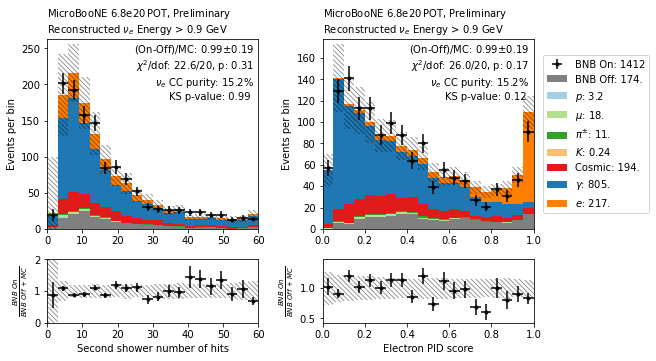

In [17]:
fig, ax = get_fig(2,1)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[0],
    "secondshower_Y_nhit",
    "Second shower number of hits",
    N_bins=20,
    x_min=0,
    x_max=60,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str=title_str,
    kind="pdg",
)
plot_class.add_text(ax[0][0], [ratio,purity,ks_p,cnp], text_loc)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[1],
    "score",
    r"Electron PID score",
    N_bins=20,
    x_min=0,
    x_max=1,
    legend=True,
    query="e_candidate>0 & preselect",
    title_str=title_str,
    kind="pdg",
)
plot_class.add_text(ax[0][1], [ratio,purity,ks_p,cnp], text_loc)

fig.savefig(output_dir + "e_cand_3.pdf", bbox_inches="tight")

## Other daughter fields
1. feature trk_llr_pid_score_v (0.382910)
2. feature trk_distance_v (0.201966)
3. feature e_candidate_anglediff (0.081999)
4. feature trk_proton_hypothesis_ratio_v (0.071988)
5. feature trk_score_v (0.068836)
6. feature trk_muon_hypothesis_ratio_v (0.067883)
7. feature pfp_shr_daughters_v (0.050025)
8. feature pfp_generation_v (0.037862)
9. feature pfp_trk_daughters_v (0.036532)

MC category: $p$: 1069. 	#entries 50228
MC category: $\mu$: 718. 	#entries 10353
MC category: $\pi^{\pm}$: 399. 	#entries 16687
MC category: $K$: 4.8 	#entries 196
MC category: Cosmic: 1174. 	#entries 37833
MC category: $\gamma$: 1053. 	#entries 23654
MC category: $e$: 148. 	#entries 24382
Calculating ratio and purity
Systematics only supported for one row per event
MC stat fractional errs: 0.49%
Covariance matrices supported for one daughter per event, max found: 15.0


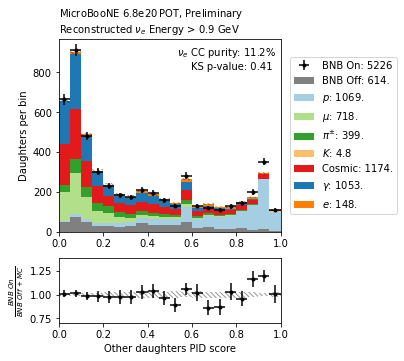

In [18]:
fig, ax = get_fig(1,1)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T,
    "score",
    "Other daughters PID score",
    N_bins=20,
    x_min=0,
    x_max=1,
    query="~e_candidate>0 & preselect",
    legend=True,
    title_str=title_str,
    kind="pdg",
    y_label="Daughters per bin",
)
plot_class.add_text(ax[0], [None,purity,ks_p,None], text_loc)

fig.savefig(output_dir + "daughters_bdt.pdf", bbox_inches="tight")

MC category: $p$: 1069. 	#entries 50228
MC category: $\mu$: 718. 	#entries 10353
MC category: $\pi^{\pm}$: 399. 	#entries 16687
MC category: $K$: 4.8 	#entries 196
MC category: Cosmic: 1174. 	#entries 37833
MC category: $\gamma$: 1053. 	#entries 23654
MC category: $e$: 148. 	#entries 24382
Obtained ratio and purity from dict
Covariance matrices supported for one daughter per event, max found: 15.0
MC category: $p$: 1069. 	#entries 50228
MC category: $\mu$: 718. 	#entries 10353
MC category: $\pi^{\pm}$: 399. 	#entries 16687
MC category: $K$: 4.8 	#entries 196
MC category: Cosmic: 1174. 	#entries 37833
MC category: $\gamma$: 1053. 	#entries 23654
MC category: $e$: 148. 	#entries 24382
Obtained ratio and purity from dict
Covariance matrices supported for one daughter per event, max found: 15.0
MC category: $p$: 1069. 	#entries 50228
MC category: $\mu$: 718. 	#entries 10353
MC category: $\pi^{\pm}$: 399. 	#entries 16687
MC category: $K$: 4.8 	#entries 196
MC category: Cosmic: 1174. 	#entri

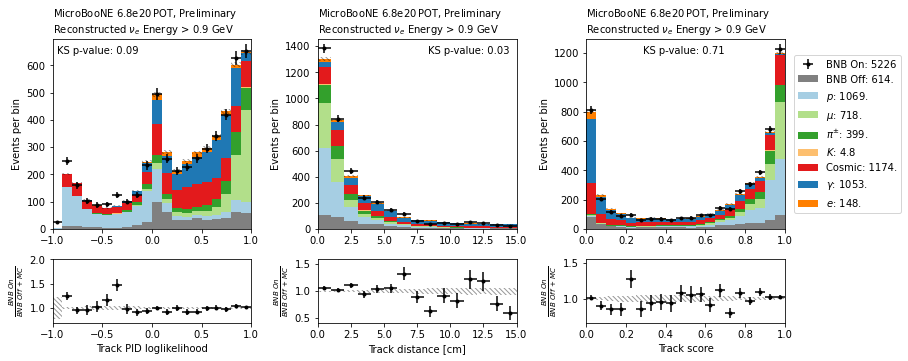

In [19]:
fig, ax = get_fig(3,1)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[0],
    "trk_llr_pid_score_v",
    "Track PID loglikelihood",
    N_bins=20,
    x_min=-1,
    x_max=1,
    query="~e_candidate>0 & preselect",
    legend=False,
    title_str=title_str,
    kind="pdg",
)
plot_class.add_text(ax[0][0], [None,None,ks_p,None], text_loc)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[1],
    "trk_distance_v",
    "Track distance [cm]",
    N_bins=15,
    x_min=0,
    x_max=15,
    query="~e_candidate>0 & preselect",
    legend=False,
    title_str=title_str,
    kind="pdg",
)
plot_class.add_text(ax[0][1], [None,None,ks_p,None], text_loc)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[2],
    "trk_score_v",
    "Track score",
    N_bins=20,
    x_min=0,
    x_max=1,
    query="~e_candidate>0 & preselect",
    legend=True,
    title_str=title_str,
    kind="pdg",
)
plot_class.add_text(ax[0][2], [None,None,ks_p,None], text_loc)

fig.savefig(output_dir + "pre_daughter_1.pdf", bbox_inches="tight")

MC category: $p$: 1069. 	#entries 50228
MC category: $\mu$: 718. 	#entries 10353
MC category: $\pi^{\pm}$: 399. 	#entries 16687
MC category: $K$: 4.8 	#entries 196
MC category: Cosmic: 1174. 	#entries 37833
MC category: $\gamma$: 1053. 	#entries 23654
MC category: $e$: 148. 	#entries 24382
Obtained ratio and purity from dict
Covariance matrices supported for one daughter per event, max found: 15.0
MC category: $p$: 1069. 	#entries 50228
MC category: $\mu$: 718. 	#entries 10353
MC category: $\pi^{\pm}$: 399. 	#entries 16687
MC category: $K$: 4.8 	#entries 196
MC category: Cosmic: 1174. 	#entries 37833
MC category: $\gamma$: 1053. 	#entries 23654
MC category: $e$: 148. 	#entries 24382
Obtained ratio and purity from dict
Covariance matrices supported for one daughter per event, max found: 15.0
MC category: $p$: 1069. 	#entries 50228
MC category: $\mu$: 718. 	#entries 10353
MC category: $\pi^{\pm}$: 399. 	#entries 16687
MC category: $K$: 4.8 	#entries 196
MC category: Cosmic: 1174. 	#entri

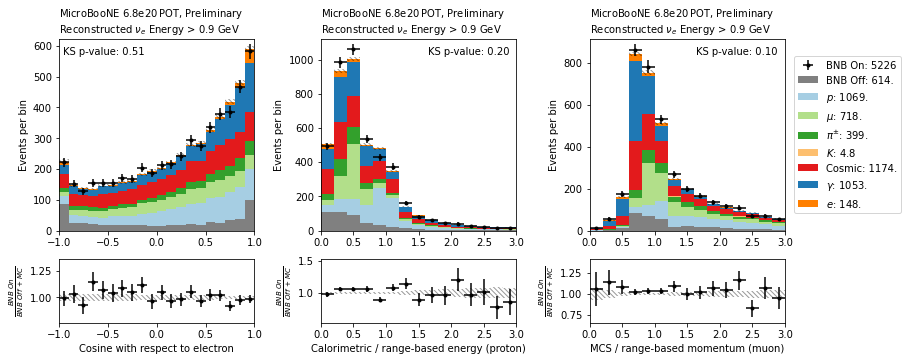

In [20]:
fig, ax = get_fig(3,1)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[0],
    "e_candidate_anglediff ",
    "Cosine with respect to electron",
    N_bins=20,
    x_min=-1,
    x_max=1,
    query="~e_candidate>0 & preselect",
    legend=False,
    title_str=title_str,
    kind="pdg",
)
plot_class.add_text(ax[0][0], [None,None,ks_p,None], text_loc)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[1],
    "trk_proton_hypothesis_ratio_v",
    "Calorimetric / range-based energy (proton)",
    N_bins=15,
    x_min=0,
    x_max=3,
    query="~e_candidate>0 & preselect",
    legend=False,
    title_str=title_str,
    kind="pdg",
)
plot_class.add_text(ax[0][1], [None,None,ks_p,None], text_loc)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[2],
    "trk_muon_hypothesis_ratio_v",
    "MCS / range-based momentum (muon)",
    N_bins=15,
    x_min=0,
    x_max=3,
    query="~e_candidate>0 & preselect",
    legend=True,
    title_str=title_str,
    kind="pdg",
)
plot_class.add_text(ax[0][2], [None,None,ks_p,None], text_loc)

fig.savefig(output_dir + "pre_daughter_2.pdf", bbox_inches="tight")

MC category: $p$: 1069. 	#entries 50228
MC category: $\mu$: 718. 	#entries 10353
MC category: $\pi^{\pm}$: 399. 	#entries 16687
MC category: $K$: 4.8 	#entries 196
MC category: Cosmic: 1174. 	#entries 37833
MC category: $\gamma$: 1053. 	#entries 23654
MC category: $e$: 148. 	#entries 24382
Obtained ratio and purity from dict
Covariance matrices supported for one daughter per event, max found: 15.0
MC category: $p$: 1069. 	#entries 50228
MC category: $\mu$: 718. 	#entries 10353
MC category: $\pi^{\pm}$: 399. 	#entries 16687
MC category: $K$: 4.8 	#entries 196
MC category: Cosmic: 1174. 	#entries 37833
MC category: $\gamma$: 1053. 	#entries 23654
MC category: $e$: 148. 	#entries 24382
Obtained ratio and purity from dict
Covariance matrices supported for one daughter per event, max found: 15.0
MC category: $p$: 1069. 	#entries 50228
MC category: $\mu$: 718. 	#entries 10353
MC category: $\pi^{\pm}$: 399. 	#entries 16687
MC category: $K$: 4.8 	#entries 196
MC category: Cosmic: 1174. 	#entri

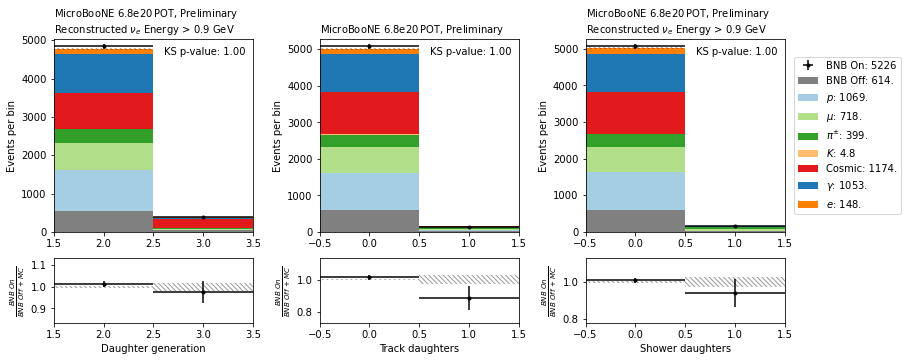

In [21]:
fig, ax = get_fig(3,1)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[0],
    "pfp_generation_v",
    "Daughter generation",
    N_bins=2,
    x_min=1.5,
    x_max=3.5,
    query="~e_candidate>0 & preselect",
    title_str=title_str,
    legend=False,
    kind="pdg",
)
plot_class.add_text(ax[0][0], [None,None,ks_p,None], 2)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[1],
    "pfp_trk_daughters_v",
    "Track daughters",
    N_bins=2,
    x_min=-0.5,
    x_max=1.5,
    query="~e_candidate>0 & preselect",
    legend=False,
    kind="pdg",
)
plot_class.add_text(ax[0][1], [None,None,ks_p,None], 2)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[2],
    "pfp_shr_daughters_v",
    "Shower daughters",
    N_bins=2,
    x_min=-0.5,
    x_max=1.5,
    query="~e_candidate>0 & preselect",
    title_str=title_str,
    legend=True,
    kind="pdg",
)
plot_class.add_text(ax[0][2], [None,None,ks_p,None], 2)

fig.savefig(output_dir + "pre_daughter_3.pdf", bbox_inches="tight")

## Combined BDT
1. feature score (0.623621)
2. feature score_other_mean (0.188310)
3. feature n_showers (0.061185)
4. feature score_other_min (0.043890)
5. feature score_other_max (0.040488)
6. feature n_pfp_farvtx (0.023708)
7. feature contained_fraction (0.018798)

MC category: $\nu_e$ CC N$\pi$: 84. 	#entries 17113
MC category: $\nu_e$ CC 0$\pi$0p: 20. 	#entries 3342
MC category: $\nu_e$ CC 0$\pi$Np: 111. 	#entries 18341
MC category: $\nu_{\mu}$ CC other: 105. 	#entries 1305
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 499. 	#entries 7680
MC category: $\nu$ NC: 27. 	#entries 768
MC category: $\nu$ NC $\pi^{0}$: 169. 	#entries 1398
MC category: Cosmic: 196. 	#entries 2830
MC category: Out of FV: 38. 	#entries 379
Obtained ratio and purity from dict
MC category: $\nu_e$ CC N$\pi$: 84. 	#entries 17113
MC category: $\nu_e$ CC 0$\pi$0p: 20. 	#entries 3342
MC category: $\nu_e$ CC 0$\pi$Np: 111. 	#entries 18341
MC category: $\nu_{\mu}$ CC other: 105. 	#entries 1305
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 499. 	#entries 7680
MC category: $\nu$ NC: 27. 	#entries 768
MC category: $\nu$ NC $\pi^{0}$: 169. 	#entries 1398
MC category: Cosmic: 196. 	#entries 2830
MC category: Out of FV: 38. 	#entries 379
Obtained ratio and purity from dict
MC category: $\nu_e$ CC N$

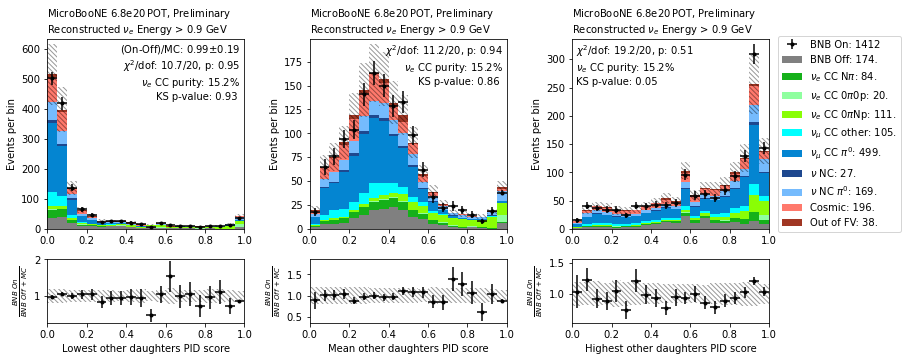

In [22]:
fig, ax = get_fig(3,1)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[0],
    "score_other_min",
    "Lowest other daughters PID score",
    N_bins=20,
    x_min=0,
    x_max=1,
    query="e_candidate>0 & preselect",
    legend=False,
    title_str=title_str,
    kind="cat",
)
plot_class.add_text(ax[0][0], [ratio,purity,ks_p,cnp], text_loc)


ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[1],
    "score_other_mean",
    "Mean other daughters PID score",
    N_bins=20,
    x_min=0,
    x_max=1,
    query="e_candidate>0 & preselect",
    legend=False,
    title_str=title_str,
    kind="cat",
)
plot_class.add_text(ax[0][1], [None,purity,ks_p,cnp], text_loc)


ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[2],
    "score_other_max",
    "Highest other daughters PID score",
    N_bins=20,
    x_min=0,
    x_max=1,
    query="e_candidate>0 & preselect",
    legend=True,
    title_str=title_str,
    kind="cat",
)
plot_class.add_text(ax[0][2], [None,purity,ks_p,cnp], text_loc)

fig.savefig(output_dir + "event_bdt_input_1.pdf", bbox_inches="tight")

MC category: $\nu_e$ CC N$\pi$: 84. 	#entries 17113
MC category: $\nu_e$ CC 0$\pi$0p: 20. 	#entries 3342
MC category: $\nu_e$ CC 0$\pi$Np: 111. 	#entries 18341
MC category: $\nu_{\mu}$ CC other: 105. 	#entries 1305
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 499. 	#entries 7680
MC category: $\nu$ NC: 27. 	#entries 768
MC category: $\nu$ NC $\pi^{0}$: 169. 	#entries 1398
MC category: Cosmic: 196. 	#entries 2830
MC category: Out of FV: 38. 	#entries 379
Obtained ratio and purity from dict
MC category: $\nu_e$ CC N$\pi$: 84. 	#entries 17113
MC category: $\nu_e$ CC 0$\pi$0p: 20. 	#entries 3342
MC category: $\nu_e$ CC 0$\pi$Np: 111. 	#entries 18341
MC category: $\nu_{\mu}$ CC other: 105. 	#entries 1305
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 499. 	#entries 7680
MC category: $\nu$ NC: 27. 	#entries 768
MC category: $\nu$ NC $\pi^{0}$: 169. 	#entries 1398
MC category: Cosmic: 196. 	#entries 2830
MC category: Out of FV: 38. 	#entries 379
Obtained ratio and purity from dict
MC category: $\nu_e$ CC N$

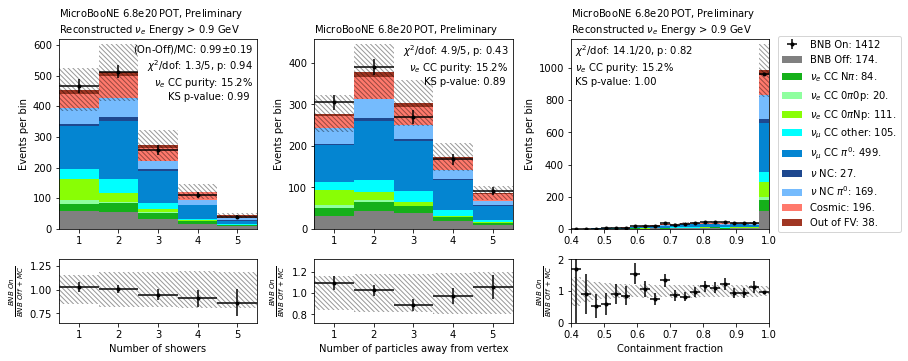

In [23]:
fig, ax = get_fig(3,1)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[0],
    "n_showers",
    r"Number of showers",
    N_bins=5,
    x_min=0.5,
    x_max=5.5,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str=title_str,
    kind="cat",
)
plot_class.add_text(ax[0][0], [ratio,purity,ks_p,cnp], text_loc)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[1],
    "n_pfp_farvtx",
    r"Number of particles away from vertex",
    N_bins=5,
    x_min=0.5,
    x_max=5.5,
    legend=False,
    query="e_candidate>0 & preselect",
    kind="cat",
)
plot_class.add_text(ax[0][1], [None,purity,ks_p,cnp], text_loc)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[2],
    "contained_fraction",
    r"Containment fraction",
    N_bins=20,
    x_min=0.4,
    x_max=1,
    legend=True,
    title_str=title_str,
    query="e_candidate>0 & preselect",
    kind="cat",
)
plot_class.add_text(ax[0][2], [None,purity,ks_p,cnp], text_loc)

fig.savefig(output_dir + "event_bdt_input_2.pdf", bbox_inches="tight")

MC category: $\nu_e$ CC N$\pi$: 84. 	#entries 17113
MC category: $\nu_e$ CC 0$\pi$0p: 20. 	#entries 3342
MC category: $\nu_e$ CC 0$\pi$Np: 111. 	#entries 18341
MC category: $\nu_{\mu}$ CC other: 105. 	#entries 1305
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 499. 	#entries 7680
MC category: $\nu$ NC: 27. 	#entries 768
MC category: $\nu$ NC $\pi^{0}$: 169. 	#entries 1398
MC category: Cosmic: 196. 	#entries 2830
MC category: Out of FV: 38. 	#entries 379
Obtained ratio and purity from dict
MC category: $\nu_e$ CC N$\pi$: 31. 	#entries 6080
MC category: $\nu_e$ CC 0$\pi$0p: 12. 	#entries 1939
MC category: $\nu_e$ CC 0$\pi$Np: 72. 	#entries 11807
MC category: $\nu_{\mu}$ CC other: 2.4 	#entries 30
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 6.3 	#entries 102
MC category: $\nu$ NC: 0.54 	#entries 20
MC category: $\nu$ NC $\pi^{0}$: 3.9 	#entries 38
MC category: Cosmic: 3.9 	#entries 112
MC category: Out of FV: 2.6 	#entries 77
Obtained ratio and purity from dict


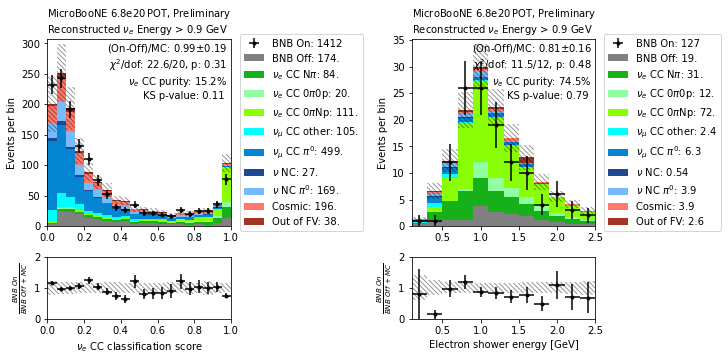

In [24]:
fig, ax = get_fig(2,1.5)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[0],
    "score_event",
    r"$\nu_e$ CC classification score",
    N_bins=20,
    x_min=0,
    x_max=1,
    query="(preselect & e_candidate)",
    legend=True,
    title_str=title_str,
    kind="cat",
)
plot_class.add_text(ax[0][0], [ratio,purity,ks_p,cnp], text_loc)


ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[1],
    "shr_energy_y_v/1000",
    "Electron shower energy [GeV]",
    N_bins=12,
    x_min=0.1,
    x_max=2.5,
    query="(select & e_candidate)",
    legend=True,
    title_str=title_str,
    kind="cat",
)
plot_class.add_text(ax[0][1], [ratio,purity,ks_p,cnp], text_loc)

[x.set_ylim(0.0, 2) for x in ax[1]]

fig.savefig(output_dir + "event_bdt.pdf", bbox_inches="tight")

MC category: $\nu_e$ CC N$\pi$: 84. 	#entries 17113
MC category: $\nu_e$ CC 0$\pi$0p: 20. 	#entries 3342
MC category: $\nu_e$ CC 0$\pi$Np: 111. 	#entries 18341
MC category: $\nu_{\mu}$ CC other: 105. 	#entries 1305
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 499. 	#entries 7680
MC category: $\nu$ NC: 27. 	#entries 768
MC category: $\nu$ NC $\pi^{0}$: 169. 	#entries 1398
MC category: Cosmic: 196. 	#entries 2830
MC category: Out of FV: 38. 	#entries 379
Obtained ratio and purity from dict
MC category: $\nu_e$ CC N$\pi$: 31. 	#entries 6080
MC category: $\nu_e$ CC 0$\pi$0p: 12. 	#entries 1939
MC category: $\nu_e$ CC 0$\pi$Np: 72. 	#entries 11807
MC category: $\nu_{\mu}$ CC other: 2.4 	#entries 30
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 6.3 	#entries 102
MC category: $\nu$ NC: 0.54 	#entries 20
MC category: $\nu$ NC $\pi^{0}$: 3.9 	#entries 38
MC category: Cosmic: 3.9 	#entries 112
MC category: Out of FV: 2.6 	#entries 77
Calculating ratio and purity
weightsFlux fractional error: 6.52%
weightsGen

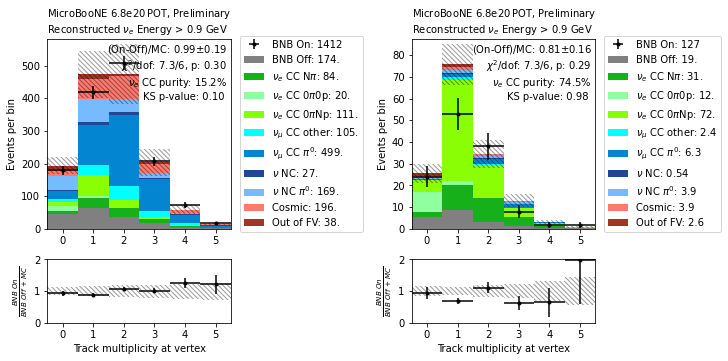

In [25]:
fig, ax = get_fig(2,1.5)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[0],
    "trk_at_vtx",
    r"Track multiplicity at vertex",
    N_bins=6,
    x_min=-0.5,
    x_max=5.5,
    legend=True,
    query="e_candidate>0 & preselect",
    title_str=title_str,
    kind="cat"
)
plot_class.add_text(ax[0][0], [ratio,purity,ks_p,cnp], text_loc)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[1],
    "trk_at_vtx",
    r"Track multiplicity at vertex",
    N_bins=6,
    x_min=-0.5,
    x_max=5.5,
    legend=True,
    query="e_candidate>0 & select",
    title_str=title_str,
    kind="cat"  
)
plot_class.add_text(ax[0][1], [ratio,purity,ks_p,cnp], text_loc)

[x.set_ylim(0.0, 2) for x in ax[1]]

fig.savefig(output_dir + "event_trk_at_vtx.pdf", bbox_inches="tight")

after_e = [
    0.0724407,
    0.069931,
    0.070793,
    0.0591427,
    0.0580825,
    0.0707208,
    0.0619271,
    0.0631596,
    0.071956,
    0.0823832,
    0.076636,
    0.0799156,
    0.0945661,
    0.107033,
    0.127387,
    0.148529,
    0.0948171,
]

after_phi = [
    0.0629107,
    0.0574177,
    0.0622805,
    0.0734858,
    0.0484628,
    0.0669408,
    0.0615361,
    0.062214,
    0.098453,
    0.0704486,
    0.0610666,
    0.063518,
]
after_theta = [
    0.0631627,
    0.0555099,
    0.0535565,
    0.0719665,
    0.0884092,
    0.071224,
    0.0889857,
    0.110553,
    0.114683,
    0.0920515,
    0.132373,
    0.349061,
]

before_e = [
    0.29716,
    0.265507,
    0.24898,
    0.260043,
    0.269309,
    0.240034,
    0.263073,
    0.279628,
    0.281871,
    0.269588,
    0.269238,
    0.280828,
    0.295573,
    0.296626,
    0.265467,
    0.293,
    0.288306,
]

before_phi = [
    0.220577,
    0.266154,
    0.241005,
    0.365799,
    0.414711,
    0.245414,
    0.222696,
    0.248814,
    0.252192,
    0.220549,
    0.263487,
    0.255388,
]

before_theta = [
    0.220855,
    0.255422,
    0.287287,
    0.245846,
    0.289416,
    0.314501,
    0.323908,
    0.286917,
    0.231717,
    0.255552,
    0.282183,
    0.406976,
]

MC category: $\nu_e$ CC N$\pi$: 31. 	#entries 6080
MC category: $\nu_e$ CC 0$\pi$0p: 12. 	#entries 1939
MC category: $\nu_e$ CC 0$\pi$Np: 72. 	#entries 11807
MC category: $\nu_{\mu}$ CC other: 2.4 	#entries 30
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 6.3 	#entries 102
MC category: $\nu$ NC: 0.54 	#entries 20
MC category: $\nu$ NC $\pi^{0}$: 3.9 	#entries 38
MC category: Cosmic: 3.9 	#entries 112
MC category: Out of FV: 2.6 	#entries 77
Obtained ratio and purity from dict
MC category: $\nu_e$ CC N$\pi$: 31. 	#entries 6080
MC category: $\nu_e$ CC 0$\pi$0p: 12. 	#entries 1939
MC category: $\nu_e$ CC 0$\pi$Np: 72. 	#entries 11807
MC category: $\nu_{\mu}$ CC other: 2.4 	#entries 30
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 6.3 	#entries 102
MC category: $\nu$ NC: 0.54 	#entries 20
MC category: $\nu$ NC $\pi^{0}$: 3.9 	#entries 38
MC category: Cosmic: 3.9 	#entries 112
MC category: Out of FV: 2.6 	#entries 77
Obtained ratio and purity from dict
MC category: $\nu_e$ CC N$\pi$: 31. 	#entries 6080
M

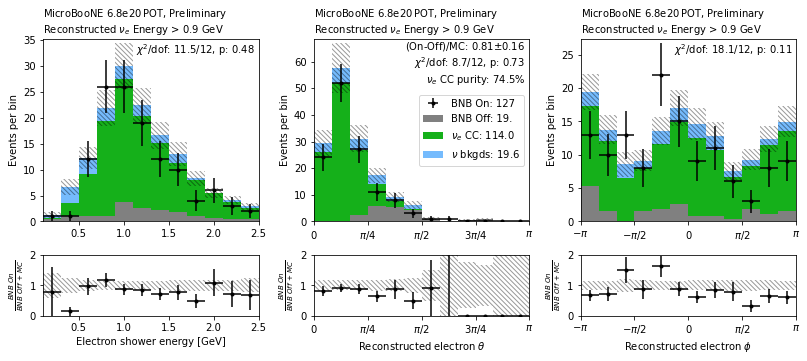

In [26]:
fig, ax = get_fig(3,0.3)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[0],
    "shr_energy_y_v/1000",
    "Electron shower energy [GeV]",
    N_bins=12,
    x_min=0.1,
    x_max=2.5,
    query="(select & e_candidate)",
    legend=False,
    title_str=title_str,
    kind="syst",
    show_data=True,
)
plot_class.add_text(ax[0][0], [None,None,None,cnp], 2)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[1],
    "shr_theta_v",
    r"Reconstructed electron $\theta$",
    N_bins=12,
    x_min=0.0,
    x_max=np.pi,
    query="(select & e_candidate)",
    legend=False,
    title_str=title_str,
    kind="syst",
    show_data=True,
)
plot_class.add_text(ax[0][1], [ratio,purity,None,cnp], text_loc)

ax[1][1].set_xticks(helper.theta_ticks)
ax[1][1].set_xticklabels(helper.theta_labs)
ax[0][1].set_xticks(helper.theta_ticks)
ax[0][1].set_xticklabels(helper.theta_labs)
ax[0][1].legend(loc="center right")

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[2],
    "trk_phi_v",
    "Reconstructed electron $\phi$",
    N_bins=12,
    x_min=-np.pi,
    x_max=np.pi,
    query="(select & e_candidate)",
    legend=False,
    title_str=title_str,
    kind="syst",
    # syst_fractions=before_phi,
    show_data=True,
)
plot_class.add_text(ax[0][2], [None,None,None,cnp], 2)
ax[1][2].set_xticks(helper.phi_ticks)
ax[1][2].set_xticklabels(helper.phi_labs)
ax[0][2].set_xticks(helper.phi_ticks)
ax[0][2].set_xticklabels(helper.phi_labs)

_ = [x.set_ylim(0.0, 2) for x in ax[1]]

fig.savefig(output_dir + "event_e_kinematics.pdf", bbox_inches="tight")

### Validation Plots

MC category: $p$: 3.2 	#entries 53
MC category: $\mu$: 18. 	#entries 225
MC category: $\pi^{\pm}$: 11. 	#entries 223
MC category: $K$: 0.24 	#entries 4
MC category: Cosmic: 194. 	#entries 2790
MC category: $\gamma$: 805. 	#entries 12324
MC category: $e$: 217. 	#entries 37537
Obtained ratio and purity from dict
MC category: $p$: 3.2 	#entries 53
MC category: $\mu$: 18. 	#entries 225
MC category: $\pi^{\pm}$: 11. 	#entries 223
MC category: $K$: 0.24 	#entries 4
MC category: Cosmic: 194. 	#entries 2790
MC category: $\gamma$: 805. 	#entries 12324
MC category: $e$: 217. 	#entries 37537
Obtained ratio and purity from dict


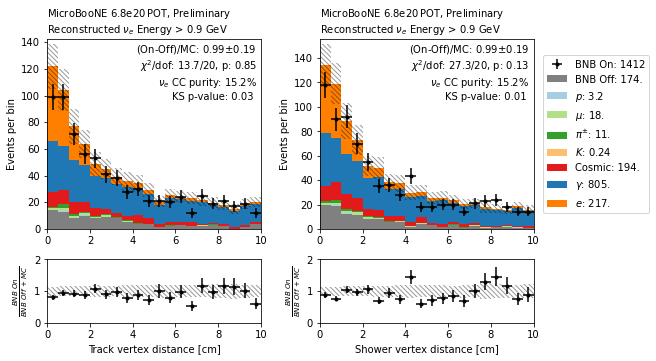

In [27]:
# Shower vs track distance
fig, ax = get_fig(2,1)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[0],
    "trk_distance_v",
    "Track vertex distance [cm]",
    N_bins=20,
    x_min=0,
    x_max=10,
    legend=False,
    title_str=title_str,
    query="e_candidate>0 & preselect",
    kind="pdg",
)
plot_class.add_text(ax[0][0], [ratio,purity,ks_p,cnp], text_loc)


ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[1],
    "shr_dist_v",
    "Shower vertex distance [cm]",
    N_bins=20,
    x_min=0,
    x_max=10,
    legend=True,
    title_str=title_str,
    query="e_candidate>0 & preselect",
    kind="pdg",
)
plot_class.add_text(ax[0][1], [ratio,purity,ks_p,cnp], text_loc)

[x.set_ylim(0.0, 2) for x in ax[1]]

fig.savefig(output_dir + "val_cand_distance.pdf", bbox_inches="tight")

MC category: $\nu_e$ CC N$\pi$: 84. 	#entries 17113
MC category: $\nu_e$ CC 0$\pi$0p: 20. 	#entries 3342
MC category: $\nu_e$ CC 0$\pi$Np: 111. 	#entries 18341
MC category: $\nu_{\mu}$ CC other: 105. 	#entries 1305
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 499. 	#entries 7680
MC category: $\nu$ NC: 27. 	#entries 768
MC category: $\nu$ NC $\pi^{0}$: 169. 	#entries 1398
MC category: Cosmic: 196. 	#entries 2830
MC category: Out of FV: 38. 	#entries 379
Obtained ratio and purity from dict
MC category: $\nu_e$ CC N$\pi$: 84. 	#entries 17113
MC category: $\nu_e$ CC 0$\pi$0p: 20. 	#entries 3342
MC category: $\nu_e$ CC 0$\pi$Np: 111. 	#entries 18341
MC category: $\nu_{\mu}$ CC other: 105. 	#entries 1305
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 499. 	#entries 7680
MC category: $\nu$ NC: 27. 	#entries 768
MC category: $\nu$ NC $\pi^{0}$: 169. 	#entries 1398
MC category: Cosmic: 196. 	#entries 2830
MC category: Out of FV: 38. 	#entries 379
Obtained ratio and purity from dict
MC category: $\nu_e$ CC N$

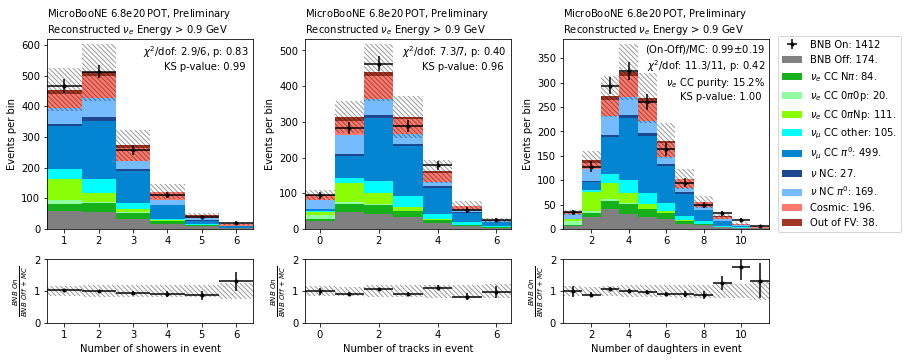

In [28]:
# number of objects after preselection

fig, ax = get_fig(3,1)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[0],
    "n_showers",
    r"Number of showers in event",
    N_bins=6,
    x_min=0.5,
    x_max=6.5,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str=title_str,
    kind="cat"
)
plot_class.add_text(ax[0][0], [None,None,ks_p,cnp], text_loc)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[1],
    "n_tracks",
    r"Number of tracks in event",
    N_bins=7,
    x_min=-0.5,
    x_max=6.5,
    legend=False,
    query="e_candidate>0 & preselect",
    title_str=title_str,
    kind="cat"  
)
plot_class.add_text(ax[0][1], [None,None,ks_p,cnp], text_loc)


ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[2],
    "n_tracks+n_showers",
    r"Number of daughters in event",
    N_bins=11,
    x_min=0.5,
    x_max=11.5,
    legend=True,
    query="e_candidate>0 & preselect",
    title_str=title_str,
    kind="cat"  
)
plot_class.add_text(ax[0][2], [ratio,purity,ks_p,cnp], text_loc)

[x.set_ylim(0.0, 2) for x in ax[1]]

fig.savefig(output_dir + "val_event_daughters_presel.pdf", bbox_inches="tight")

MC category: $\nu_e$ CC N$\pi$: 31. 	#entries 6080
MC category: $\nu_e$ CC 0$\pi$0p: 12. 	#entries 1939
MC category: $\nu_e$ CC 0$\pi$Np: 72. 	#entries 11807
MC category: $\nu_{\mu}$ CC other: 2.4 	#entries 30
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 6.3 	#entries 102
MC category: $\nu$ NC: 0.54 	#entries 20
MC category: $\nu$ NC $\pi^{0}$: 3.9 	#entries 38
MC category: Cosmic: 3.9 	#entries 112
MC category: Out of FV: 2.6 	#entries 77
Obtained ratio and purity from dict
MC category: $\nu_e$ CC N$\pi$: 31. 	#entries 6080
MC category: $\nu_e$ CC 0$\pi$0p: 12. 	#entries 1939
MC category: $\nu_e$ CC 0$\pi$Np: 72. 	#entries 11807
MC category: $\nu_{\mu}$ CC other: 2.4 	#entries 30
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 6.3 	#entries 102
MC category: $\nu$ NC: 0.54 	#entries 20
MC category: $\nu$ NC $\pi^{0}$: 3.9 	#entries 38
MC category: Cosmic: 3.9 	#entries 112
MC category: Out of FV: 2.6 	#entries 77
Obtained ratio and purity from dict
MC category: $\nu_e$ CC N$\pi$: 31. 	#entries 6080
M

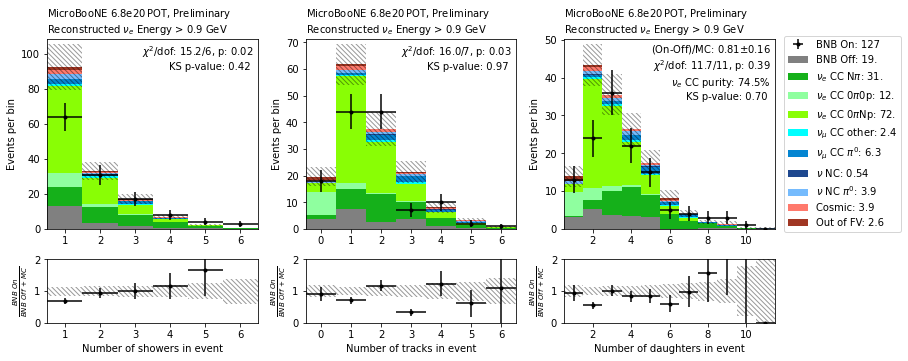

In [29]:
# number of objects after selection

fig, ax = get_fig(3,1)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[0],
    "n_showers",
    r"Number of showers in event",
    N_bins=6,
    x_min=0.5,
    x_max=6.5,
    legend=False,
    query="e_candidate>0 & select",
    title_str=title_str,
    kind="cat"
)
plot_class.add_text(ax[0][0], [None,None,ks_p,cnp], text_loc)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[1],
    "n_tracks",
    r"Number of tracks in event",
    N_bins=7,
    x_min=-0.5,
    x_max=6.5,
    legend=False,
    query="e_candidate>0 & select",
    title_str=title_str,
    kind="cat"  
)
plot_class.add_text(ax[0][1], [None,None,ks_p,cnp], text_loc)


ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[2],
    "n_tracks+n_showers",
    r"Number of daughters in event",
    N_bins=11,
    x_min=0.5,
    x_max=11.5,
    legend=True,
    query="e_candidate>0 & select",
    title_str=title_str,
    kind="cat"  
)
plot_class.add_text(ax[0][2], [ratio,purity,ks_p,cnp], text_loc)

[x.set_ylim(0.0, 2) for x in ax[1]]

fig.savefig(output_dir + "val_event_daughters_sel.pdf", bbox_inches="tight")

MC category: $\nu_e$ CC N$\pi$: 31. 	#entries 6080
MC category: $\nu_e$ CC 0$\pi$0p: 12. 	#entries 1939
MC category: $\nu_e$ CC 0$\pi$Np: 72. 	#entries 11807
MC category: $\nu_{\mu}$ CC other: 2.4 	#entries 30
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 6.3 	#entries 102
MC category: $\nu$ NC: 0.54 	#entries 20
MC category: $\nu$ NC $\pi^{0}$: 3.9 	#entries 38
MC category: Cosmic: 3.9 	#entries 112
MC category: Out of FV: 2.6 	#entries 77
Obtained ratio and purity from dict
MC category: $\nu_e$ CC N$\pi$: 31. 	#entries 6080
MC category: $\nu_e$ CC 0$\pi$0p: 12. 	#entries 1939
MC category: $\nu_e$ CC 0$\pi$Np: 72. 	#entries 11807
MC category: $\nu_{\mu}$ CC other: 2.4 	#entries 30
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 6.3 	#entries 102
MC category: $\nu$ NC: 0.54 	#entries 20
MC category: $\nu$ NC $\pi^{0}$: 3.9 	#entries 38
MC category: Cosmic: 3.9 	#entries 112
MC category: Out of FV: 2.6 	#entries 77
Obtained ratio and purity from dict
MC category: $\nu_e$ CC N$\pi$: 31. 	#entries 6080
M

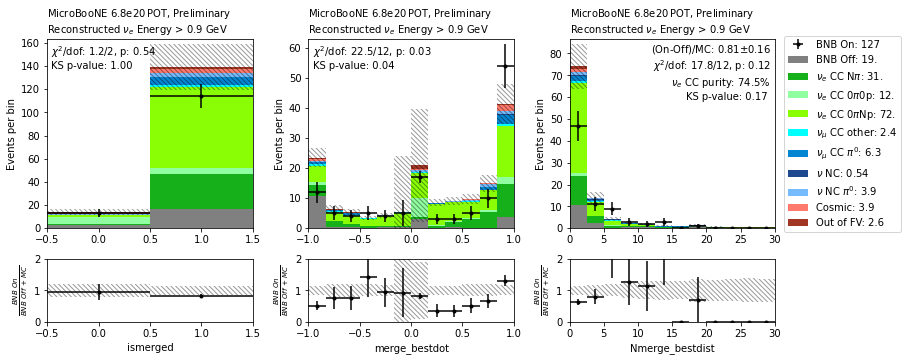

In [30]:
# number of objects after preselection
#"merge_bestdot",
#"merge_bestdist",
#"ismerged",

fig, ax = get_fig(3,1)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[0],
    "ismerged",
    r"ismerged",
    N_bins=2,
    x_min=-0.5,
    x_max=1.5,
    legend=False,
    query="e_candidate>0 & select",
    title_str=title_str,
    kind="cat"
)
plot_class.add_text(ax[0][0], [None,None,ks_p,cnp], text_loc)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[1],
    "merge_bestdot",
    r"merge_bestdot",
    N_bins=12,
    x_min=-1,
    x_max=1,
    legend=False,
    query="e_candidate>0 & select",
    title_str=title_str,
    kind="cat"  
)
plot_class.add_text(ax[0][1], [None,None,ks_p,cnp], text_loc)


ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax.T[2],
    "merge_bestdist",
    r"Nmerge_bestdist",
    N_bins=12,
    x_min=0,
    x_max=30,
    legend=True,
    query="e_candidate>0 & select",
    title_str=title_str,
    kind="cat"  
)
plot_class.add_text(ax[0][2], [ratio,purity,ks_p,cnp], text_loc)

[x.set_ylim(0.0, 2) for x in ax[1]]

fig.savefig(output_dir + "val_merge_sel.pdf", bbox_inches="tight")

MC category: $\nu_e$ CC N$\pi$: 31. 	#entries 6080
MC category: $\nu_e$ CC 0$\pi$0p: 12. 	#entries 1939
MC category: $\nu_e$ CC 0$\pi$Np: 72. 	#entries 11807
MC category: $\nu_{\mu}$ CC other: 2.4 	#entries 30
MC category: $\nu_{\mu}$ CC $\pi^{0}$: 6.3 	#entries 102
MC category: $\nu$ NC: 0.54 	#entries 20
MC category: $\nu$ NC $\pi^{0}$: 3.9 	#entries 38
MC category: Cosmic: 3.9 	#entries 112
MC category: Out of FV: 2.6 	#entries 77
Obtained ratio and purity from dict


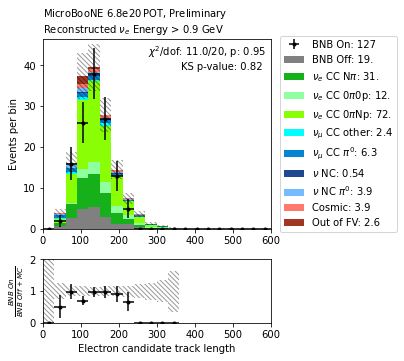

In [31]:
fig, ax = get_fig(1,1)

ratio, purity, ks_p, cnp, text_loc = plotter.plot_panel_data_mc(
    ax,
    "trk_len_v",
    r"Electron candidate track length",
    N_bins=20,
    x_min=0,
    x_max=600,
    legend=True,
    query="e_candidate>0 & select",
    title_str=title_str,
    kind="cat"
)
plot_class.add_text(ax[0], [None,None,ks_p,cnp], text_loc)


fig.savefig(output_dir + "val_e_cand_trk_len.pdf", bbox_inches="tight")